This notebook is to train and evaulate the NN QC model on all 50+ gauge locations 

In [1]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import dill
import pickle
from scipy import io
from scipy.signal import detrend as detrend
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#My helper functions
from modelNN_functions import assessTrainTestData
from modelNN_functions import plotConfusionMatrix
from modelNN_functions import pandasToMat
from modelNN_functions import BSS
from modelNN_functions import loadCleanedData
from modelNN_functions import resampleGoodPointsSetNum

In [2]:
#Define the NN model to be used for the QC (good or bad 1=good, 0=bad)

def runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets, 
               predictStations, epochCount, batchCount, classThreshold, numFeatures):

    """
    where: 
        featureTrain = features used in training the model
        targetTrain = targets (0 or 1) used in training the model
        featureTest = features used for validation
        targetTest = targets (0 or 1) used for valdation
        predictFeatures = the features for the model predictions
        predictTargets = the targets for the model predictions
        predictStations = the stations for the model predictions
        epochCount = number of training cycles to use for NN model (10-20 seems reasonable)
        batchCount = the batch size to use when training (somewhere from 32-256 seems reasonable)
        classThreshold = the threshold from 0 to 1 used to classify a point as good or bad (default is 0.5)
        numFeatures = the number of input features in the NN model
    """

    #First define the keras NN framework to be used
    # For a single-input model with 2 classes (binary classification):
    model = Sequential()
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_dim=numFeatures))
    model.add(Dense(32, activation='relu', input_dim=numFeatures))
    model.add(Dropout(0.25))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(32, activation='relu', input_dim=numFeatures))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    
    #Set up the model checkpoint
    # checkpoint
    filepath="model_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    # Train the model, iterating on the data in batches of X # samples (somewhere between 32 - 256)
    history = model.fit(featureTrain, targetTrain, epochs=epochCount, batch_size=batchCount, validation_data=(featureTest, targetTest), callbacks=callbacks_list)
    
    # Load the best performing model run
    model = load_model('model_best.hdf5')
    
    #Evaulate the model
    eval_model=model.evaluate(featureTest, targetTest)
    eval_model
    
    #Plot the NN accuracy over each epoch
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.legend(['Training','Validation'])
    plt.show()
    #fig.savefig('NN_modelTrainingHistory.png')
    
    #Generate predictions for the test period
    modelPrediction = model.predict(featureTest, batch_size=32)

    #And now use the threhsold to decide y or n
    modelPredThresh=1*(modelPrediction >= classThreshold)

    # Compute confusion matrix
    cnfMatrix = confusion_matrix(targetTest, modelPredThresh)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    classNames = ['bad data point','good data point']
    plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                      title='Confusion matrix, with normalization')
    plt.show()
    
    #Generate model predictions for the validation period
    modelPrediction = model.predict(predictFeatures, batch_size=32)
    #Generate the y/n prediction given the above model threshold value (right now = 0.9)
    modelPredThresh=1*(modelPrediction >= classThreshold)
    
    modelOut = pd.DataFrame()
    modelOut['primary'] = predictFeatures['PRIMARY']
    modelOut['modelPrediction']=modelPrediction
    modelOut['InvModelPrediction']=1-modelPrediction
    modelOut['goodPtsPrediction']=modelPredThresh
    modelOut['target'] = predictTargets['TARGET']
    modelOut['station'] = predictStations['STATION_ID']
    
    return modelOut, model


In [3]:
#Create the station list 
#Grab the station list by default from the directory of files
# dirList = os.listdir('/jupyter/userhomes/dusek/waterlevelAI/data/train')
dirList = os.listdir('C:/Users/Lindsay.Abrams/Documents/NOAA-WL-AI/processed_4cm/train')
stationList = []
for file in dirList:
    if not file.startswith('.'):
        stationList.append(file[:7])
        
#removing south beach for now - has some sort of issue
#stationList.remove('9435380')

#Create performance dataframe
#Make the modelPerformanceDataFrame to store info about each station and error stats
modelPerformance = pd.DataFrame()
stationList.insert(0,'allStations')
modelPerformance['stationList'] = stationList
modelPerformance.set_index('stationList',inplace = True)

modelPerformance['trainingPts'] = np.nan
modelPerformance['trainingFractionBad'] = np.nan
modelPerformance['valPts'] = np.nan
modelPerformance['valFractionBad'] = np.nan

modelPerformance['accuracy'] = np.nan
modelPerformance['badPtAccuracy'] = np.nan
modelPerformance['BSS'] = np.nan
modelPerformance['AROC'] = np.nan

In [4]:
# for each station in my list of stations I want to include, load the training data and validation data.  
# Also - resample to create data sets that are 10% bad data points and then cat together

# For each station in list load the training and validation data, print the data counts, resample and cat together
trainAll = pd.DataFrame()
validateAll = pd.DataFrame()
allTrainData=0
allTrainBadData=0
allValData=0
allValBadData=0

for station in stationList[1:]:
    print(station)
    #load the training data
    trainIn = loadCleanedData(station, 'train', 'C:/Users/Lindsay.Abrams/Documents/NOAA-WL-AI/processed_4cm/')
    validateIn = loadCleanedData(station, 'validation', 'C:/Users/Lindsay.Abrams/Documents/NOAA-WL-AI/processed_4cm/')
    
    #Remove all cases where PRIMARY_TRUE = 0, since then the primary data is missing, and we aren't assessing its quality
    trainIn.drop(trainIn[trainIn['PRIMARY_TRUE'] == 0].index, inplace = True) 
    validateIn.drop(validateIn[validateIn['PRIMARY_TRUE'] == 0].index, inplace = True) 
    
    #resample the training data
    trainResample = resampleGoodPointsSetNum(200000, trainIn)    
    
    #assess the data counts
    [totalTrainData,badTrainData] = assessTrainTestData(trainResample)
    [totalValData,badValData] = assessTrainTestData(validateIn)
    
    #load into the dataframe
    modelPerformance.at[station,'trainingPts'] = totalTrainData
    modelPerformance.at[station,'trainingFractionBad'] = badTrainData/totalTrainData
    modelPerformance.at[station,'valPts'] = totalValData
    modelPerformance.at[station,'valFractionBad'] = badValData/totalValData
    
    #Cat into a single dataframe
    trainAll = pd.concat([trainAll, trainResample])
    validateAll = pd.concat([validateAll, validateIn])
    
    #Calculate the total data numbers
    allTrainData= allTrainData + totalTrainData
    allTrainBadData= allTrainBadData+badTrainData
    allValData= allValData + totalValData
    allValBadData= allValBadData + badValData


#Add the total data numbers to the dataframe
modelPerformance.at['allStations','trainingPts'] = allTrainData
modelPerformance.at['allStations','trainingFractionBad'] = allTrainBadData/allTrainData
modelPerformance.at['allStations','valPts'] = allValData
modelPerformance.at['allStations','valFractionBad'] = allValBadData/allValData

# Shuffle data
trainRand=shuffle(trainAll)
validateRand=shuffle(validateAll)


modelPerformance

1612340
Random under-sampling:
1    199931
0        69
Name: TARGET, dtype: int64
1617433
Random under-sampling:
1    188299
0     11701
Name: TARGET, dtype: int64
8418150
Random under-sampling:
1    194112
0      5888
Name: TARGET, dtype: int64
8443970
Random under-sampling:
1    180090
0     19910
Name: TARGET, dtype: int64
8447386
Random under-sampling:
1    179107
0     20893
Name: TARGET, dtype: int64
8449130
Random under-sampling:
1    188291
0     11709
Name: TARGET, dtype: int64
8452660
Random under-sampling:
1    176189
0     23811
Name: TARGET, dtype: int64
8452944
Random under-sampling:
1    162621
0     37379
Name: TARGET, dtype: int64
8454049
Random under-sampling:
1    186046
0     13954
Name: TARGET, dtype: int64
8461490
Random under-sampling:
1    173009
0     26991
Name: TARGET, dtype: int64
8510560
Random under-sampling:
1    188972
0     11028
Name: TARGET, dtype: int64
8534720
Random under-sampling:
1    193580
0      6420
Name: TARGET, dtype: int64
8536110
Random u

,trainingPts,trainingFractionBad,valPts,valFractionBad,accuracy,badPtAccuracy,BSS,AROC
stationList,,,,,,,,
allStations,3000000.0,0.091305,2593276.0,0.020395,NaN,NaN,NaN,NaN
1612340,200000.0,0.000345,175160.0,0.000023,NaN,NaN,NaN,NaN
1617433,200000.0,0.058505,172421.0,0.000006,NaN,NaN,NaN,NaN
8418150,200000.0,0.029440,175151.0,0.009860,NaN,NaN,NaN,NaN
8443970,200000.0,0.099550,166380.0,0.001599,NaN,NaN,NaN,NaN
8447386,200000.0,0.104465,174255.0,0.016413,NaN,NaN,NaN,NaN
8449130,200000.0,0.058545,173082.0,0.018471,NaN,NaN,NaN,NaN
8452660,200000.0,0.119055,170839.0,0.148760,NaN,NaN,NaN,NaN
8452944,200000.0,0.186895,174469.0,0.000556,NaN,NaN,NaN,NaN


In [5]:
# Now set up the model inputs 

featureNames = ['PRIMARY','PRIMARY_SIGMA','PRIMARY_SIGMA_TRUE','PRIMARY_RESIDUAL','BACKUP','BACKUP_TRUE','PREDICTION',]

featureTrain=trainRand.loc[:, featureNames]
featureVal=validateRand.loc[:, featureNames]

targetTrain=trainRand.loc[:,['TARGET']]
targetVal=validateRand.loc[:,['TARGET']]


predictFeatures = validateAll.loc[:, featureNames]
predictTargets = validateAll.loc[:,['TARGET']]
predictStations = validateAll.loc[:,['STATION_ID']]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11719/11719 [==============================

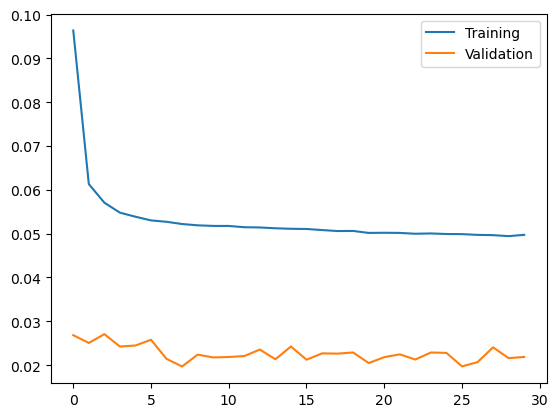

81040/81040 [==============================] - 76s 941us/step
Normalized confusion matrix
[[0.9 0.1]
 [0.  1. ]]
total accuracy = 0.9961


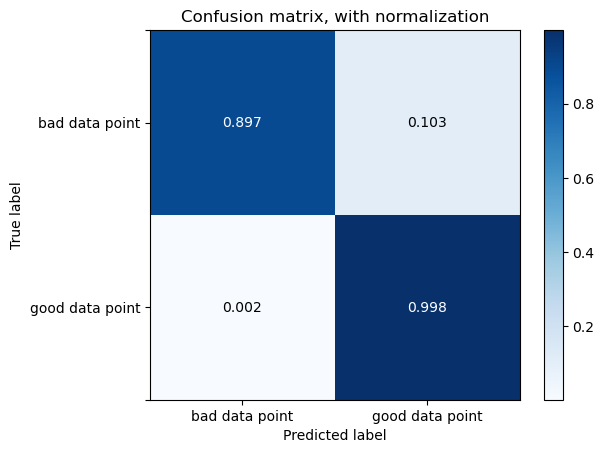

81040/81040 [==============================] - 77s 952us/step


In [6]:
#NN approach - 10% no - Simple model - with 32x2 and 0.25% dropout

epochCount = 30
batchCount = 256
classThreshold = .50
numFeatures = len(featureNames)
modelOut_simple, model_simple = runNNmodel(featureTrain, targetTrain, featureVal, targetVal, predictFeatures, predictTargets,
               predictStations, epochCount, batchCount, classThreshold, numFeatures)

In [7]:
#The climatology comparison for the BSS will be accross all stations no matter what
targetClimIn = targetTrain.to_numpy()

#Loop through first all stations and then by station to calculate error stats
for stationNum in modelPerformance.index:
      
    if stationNum == 'allStations':  
        #define variables
        goodPtsPredIn = modelOut_simple['goodPtsPrediction']
        obsTargetIn = modelOut_simple['target'].to_numpy()
        onlyBadPoints = modelOut_simple[modelOut_simple['target'] == 0]
        goodPtsPredOnlyBadIn = onlyBadPoints['goodPtsPrediction']
        obsTargetOnlyBadIn = onlyBadPoints['target']
        modPredIn = modelOut_simple['modelPrediction'].to_numpy()   
    else:
        #define station specific variables
        goodPtsPredIn = modelOut_simple[modelOut_simple['station']==int(stationNum)]['goodPtsPrediction']
        obsTargetIn = modelOut_simple[modelOut_simple['station']==int(stationNum)]['target'].to_numpy()
        onlyBadPoints = modelOut_simple[modelOut_simple['target'] == 0]
        goodPtsPredOnlyBadIn = onlyBadPoints[onlyBadPoints['station']==int(stationNum)]['goodPtsPrediction']
        obsTargetOnlyBadIn = onlyBadPoints[onlyBadPoints['station']==int(stationNum)]['target']
        modPredIn =modelOut_simple[modelOut_simple['station']==int(stationNum)]['modelPrediction'].to_numpy()   
        
    
    #Calculate the values
    modelPerformance.at[stationNum,'accuracy'] = 1 - np.sum(np.abs(goodPtsPredIn - obsTargetIn))/len(goodPtsPredIn) 

    #Bad Pt Accuracy
    modelPerformance.at[stationNum,'badPtAccuracy'] = 1 - np.sum(np.abs(goodPtsPredOnlyBadIn - obsTargetOnlyBadIn  ))/len(obsTargetOnlyBadIn) 

    #BSS
    modelPerformance.at[stationNum,'BSS'] = BSS(targetClimIn, modPredIn, obsTargetIn)

    #AROC
    modelPerformance.at[stationNum,'AROC'] = roc(obsTargetIn,np.reshape(modPredIn,-1))

        
modelPerformance    

,trainingPts,trainingFractionBad,valPts,valFractionBad,accuracy,badPtAccuracy,BSS,AROC
stationList,,,,,,,,
allStations,3000000.0,0.091305,2593276.0,0.020395,0.996115,0.896636,0.847775,0.987361
1612340,200000.0,0.000345,175160.0,0.000023,1.000000,1.000000,0.999882,1.000000
1617433,200000.0,0.058505,172421.0,0.000006,0.999994,1.000000,0.999458,1.000000
8418150,200000.0,0.029440,175151.0,0.009860,0.999783,0.990735,0.986930,0.999993
8443970,200000.0,0.099550,166380.0,0.001599,0.998870,0.868421,0.910777,0.980356
8447386,200000.0,0.104465,174255.0,0.016413,0.999931,0.995804,0.994962,0.999978
8449130,200000.0,0.058545,173082.0,0.018471,0.988243,0.985612,0.405186,0.999214
8452660,200000.0,0.119055,170839.0,0.148760,0.980227,0.869678,0.853042,0.979997
8452944,200000.0,0.186895,174469.0,0.000556,0.998716,0.164948,0.863752,0.914968
